In [1]:
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html 
# Install required libraries
# Import required libraries
import random
import math
import gymnasium as gym
from gymnasium import spaces
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
from itertools import count

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"
)

print(device)
CUDA_LAUNCH_BLOCKING=1

cuda


In [2]:
# imports are always needed
import torch
# get index of currently selected device
torch.cuda.current_device() # returns 0 in my case
# get number of GPUs available
torch.cuda.device_count() # returns 1 in my case
# get the name of the device
torch.cuda.get_device_name(0) # good old Tesla K80


'NVIDIA GeForce GTX 1660 SUPER'

In [6]:

# modify this to fit current environment 
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
class DQN(nn.Module):

    def __init__(self, obs, action):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(obs, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, action)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    
class agent():
    def __init__(self,obs,actions):
        self.actions = actions
        self.batch = 128
        self.discount_factor = 0.99
        self.eps = 1
        self.eps_decay = 0.9954
        # self.tau = 0.005
        self.learning_rate = 0.1
        self.memory = ReplayMemory(5000) # replay memory 
        # self.policy_net = DQN(obs, actions).to(device) # action value function
        # self.target_net = DQN(obs, actions).to(device) # target action value function 
        self.policy_net = DQN(obs, actions)
        self.target_net = DQN(obs, actions)
        self.optimizer = optim.SGD(self.policy_net.parameters(), lr=0.01)
        self.Q_table = self.print_table() # not working rn
        
    
    def select_action(self,state):
        p = random.random()
        if p < self.eps:
            #random action
            return torch.tensor([[env.action_space.sample()]], dtype=torch.long)
        else:
            #best action
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                return self.policy_net(state).max(1).indices.view(1, 1)

    def update(self,timestep,episode,terminated):
        #update weight every 5 steps
        t = timestep +1
        if t%5 == 0:
            #sample and train policy_net
            self.replay()
        #update target_net every 5 eps, If solved, set as target_net
        ep = episode+1
        if ep+1%5 == 0 or terminated == True:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        return 
    
    def replay(self):
        if len(agent.memory) < self.batch:
            return
        else:
            print("sample")
            sample = self.memory.sample(self.batch)
            q_values_list = []
            target_list = []
            for state, action, next_state, reward in sample:
                if next_state == None:
                    target = reward
                else:
                    with torch.no_grad():
                        #predict target Q-values
                        q = self.target_net(next_state).max(1)[0]
                        next_q = q.item() #predict next state with target network 
                        target = (reward + self.discount_factor * np.amax(next_q))
                q_values = self.policy_net(state)[0][action].item()#predict with policy network
                q_values_list.append(q_values)
                target_list.append(target)
           # Set loss function 
            loss = nn.MSELoss()
            # Set action lists require grad
            state_action_list = torch.FloatTensor(q_values_list)
            state_action_list.requires_grad = True
            target_list = torch.FloatTensor(target_list)
            target_list.requires_grad = True
            # back prop
            self.optimizer.zero_grad()
            output = loss(state_action_list, target_list.unsqueeze(1))
            output.backward()
            self.optimizer.step()

            return 
        #replay algorithim here
    def print_table(self): # not working rn
        
        return



env = gym.make("CartPole-v1")
state, info = env.reset()
obs = len(state)
actions = env.action_space.n
agent = agent(obs,actions)
        
    

loop end at: 25
loop end at: 16
loop end at: 14
loop end at: 19
loop end at: 30
loop end at: 16
sample
sample
sample
sample
sample
sample
sample


C:\Users\Dan\Downloads\Python\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


sample
sample
loop end at: 45
sample
sample
sample
loop end at: 15
sample
sample
loop end at: 13
sample
sample
sample
loop end at: 17
solved False


<Figure size 640x480 with 0 Axes>

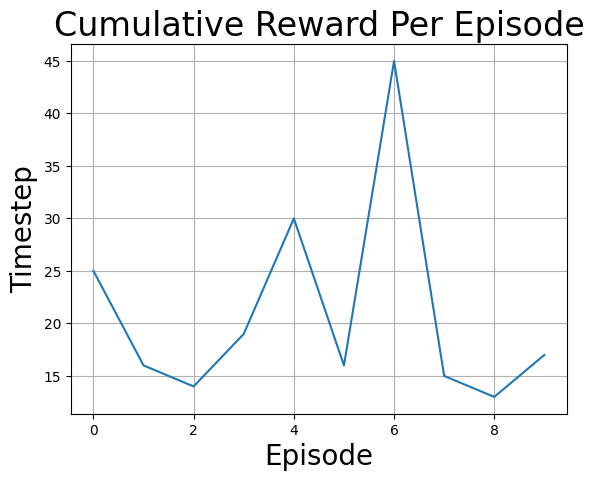

In [4]:
#create environment to run DQN
env = gym.make("CartPole-v1")

max_episodes = 10
max_timestep = 500
state, info = env.reset()
obs = len(state)
actions = env.action_space.n
# agent = agent(obs,actions)
reward_per_episode = []
for episode in range(max_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    terminated,truncated = False, False
    for timestep in range(500):
        action = agent.select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward +=timestep
        if terminated:
            next_state = None #used to check if object has fallen during replay
        else:
            next_state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

        agent.memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        agent.update(timestep=timestep,episode=episode,terminated=truncated) #update network weights
        if terminated or truncated: # close loop if it ends
            print('loop end at:', timestep)
            reward_per_episode.append(timestep)
            break
    agent.eps = agent.eps * agent.eps_decay #eps decay

print('solved',truncated)
plt.figure()
fig ,  ax = plt.subplots()
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Timestep', fontsize=20)
plt.title('Cumulative Reward Per Episode', fontsize=24)
ax.plot(reward_per_episode,linestyle='solid',label = 'Q learning')
plt.grid()
plt.show()

In [5]:
    with open("pickles/cartpole", 'wb') as file:
        pickle.dump(agent.policy_net, file)